In [1]:
# !pip install pandas
# !pip install seaborn
# !pip install statsmodels
# !pip install scikit-learn
# !pip install plotly
# !pip install nbformat

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import json
import plotly.express as px
import plotly.graph_objects as go

from statsmodels.api import OLS

from definitions import GOAL, SHOT_ON_GOAL, BLOCKED_SHOT, MISSED_SHOT, FAILED_SHOT_ATTEMPT

In [3]:
conn = sqlite3.connect('/Users/aidankosik/workspace/CSCA-5028/nhl-data-collector/datacollector/app/nhl_stats.db')

In [4]:
players_df = pd.read_sql_query("SELECT * FROM players", conn)
teams_df = pd.read_sql_query("SELECT * FROM teams", conn)
events_df = pd.read_sql_query("SELECT * FROM events", conn)
shifts_df = pd.read_sql_query("SELECT * FROM shift_charts", conn)
skater_seasons_df = pd.read_sql_query("SELECT * FROM skater_season", conn)
goalie_seasons_df = pd.read_sql_query("SELECT * FROM goalie_season", conn)
games_df = pd.read_sql_query("SELECT * FROM games", conn)

In [5]:
def createFullName(row):
    '''
    Function to format first name and last name as "last_name, first_name"
    @param row: row of a dataframe
    '''
    return row['last_name'] + ', ' + row['first_name']
players_df['full_name'] = players_df.apply(createFullName, axis=1)
players_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653 entries, 0 to 652
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              653 non-null    int64  
 1   first_name      653 non-null    object 
 2   last_name       653 non-null    object 
 3   team_id         653 non-null    object 
 4   position        653 non-null    object 
 5   shoots_catches  653 non-null    object 
 6   height          653 non-null    int64  
 7   weight          653 non-null    int64  
 8   birth_date      653 non-null    object 
 9   birth_country   653 non-null    object 
 10  sweater_number  631 non-null    float64
 11  full_name       653 non-null    object 
dtypes: float64(1), int64(3), object(8)
memory usage: 61.3+ KB


In [6]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4429 entries, 0 to 4428
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          4429 non-null   int64 
 1   date        4429 non-null   object
 2   season      4429 non-null   object
 3   game_type   4429 non-null   int64 
 4   home_id     4429 non-null   int64 
 5   away_id     4429 non-null   int64 
 6   home_goals  4429 non-null   int64 
 7   away_goals  4429 non-null   int64 
 8   winner      4429 non-null   object
dtypes: int64(6), object(3)
memory usage: 311.5+ KB


# EDA of Shifts

In [7]:
def convertDuration(row):
    '''
    Function to convert duration from MM:SS format to seconds.
    @param row: row of a dataframe
    '''
    if row['duration'] is not None:
        splits = row['duration'].split(':')
        return int(splits[0]) * 60 + int(splits[1])
    else:
        return 0
shifts_df['duration'] = shifts_df.apply(convertDuration, axis=1)
    

In [8]:
shifts_df.rename(columns={'id' : 'shift_id'}, inplace=True)
shifts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231710 entries, 0 to 3231709
Data columns (total 14 columns):
 #   Column             Dtype  
---  ------             -----  
 0   shift_id           int64  
 1   game_id            int64  
 2   player_id          int64  
 3   detail_code        float64
 4   type_code          int64  
 5   duration           int64  
 6   start_time         object 
 7   end_time           object 
 8   event_description  object 
 9   event_details      object 
 10  event_number       float64
 11  shift_number       int64  
 12  period_number      int64  
 13  hex_value          object 
dtypes: float64(2), int64(7), object(5)
memory usage: 345.2+ MB


In [9]:
player_info = players_df[['full_name', 'id']]
player_info.rename(columns={'id' : 'player_id'}, inplace=True)
# We will only consider the 2023-24 season, first join season onto shifts
shifts_df = shifts_df.merge(games_df[['id', 'season']], left_on='game_id', right_on='id')
shifts_df.drop(columns=['id'], inplace=True)
shifts_df = shifts_df[shifts_df['season'] == '20232024']
# We only want regular season games
shifts_df = shifts_df.merge(games_df[['id', 'game_type']], left_on='game_id', right_on='id')
shifts_df.drop(columns=['id'], inplace=True)
shifts_df = shifts_df[shifts_df['game_type'] == 2]
# Total number of shifts for a player
player_shifts = shifts_df.groupby('player_id')['shift_id'].nunique().reset_index(name='num_shifts')
# Total duration of shifts for a player (in seconds)
player_shifts_duration = shifts_df.groupby('player_id')['duration'].sum().reset_index(name='total_duration')
# Number of games played by a player (with at least 1 shift)
player_games = shifts_df.groupby('player_id')['game_id'].nunique().reset_index(name='num_games')
# Join all the above dataframes to player_info
player_info = player_info.merge(player_shifts, on='player_id')
player_info = player_info.merge(player_shifts_duration, on='player_id')
player_info = player_info.merge(player_games, on='player_id')
player_info.info()

/var/folders/d6/3wvcj62d23z0cs353m5_sgtc0000gn/T/ipykernel_5372/2129978966.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_info.rename(columns={'id' : 'player_id'}, inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 603 entries, 0 to 602
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   full_name       603 non-null    object
 1   player_id       603 non-null    int64 
 2   num_shifts      603 non-null    int64 
 3   total_duration  603 non-null    int64 
 4   num_games       603 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 23.7+ KB


In [10]:
# Let's weight shifts and duration by the number of games played
player_info['shifts_per_game'] = player_info['num_shifts'] / player_info['num_games']
player_info['duration_per_game'] = player_info['total_duration'] / player_info['num_games']
player_info['duration_per_shift'] = player_info['total_duration'] / player_info['num_shifts']
print(player_info['shifts_per_game'].describe())
print(player_info['duration_per_game'].describe())
print(player_info['duration_per_shift'].describe())

count    603.000000
mean      19.168929
std        6.395251
min        3.000000
25%       16.595455
50%       20.675325
75%       23.358465
max       31.230769
Name: shifts_per_game, dtype: float64
count     603.000000
mean     1221.212911
std       746.766472
min       123.000000
25%       840.250321
50%      1038.951220
75%      1225.055463
max      3648.250000
Name: duration_per_game, dtype: float64
count     603.000000
mean      130.017127
std       257.018479
min        32.100000
25%        44.472981
50%        47.763261
75%        52.009444
max      1200.000000
Name: duration_per_shift, dtype: float64


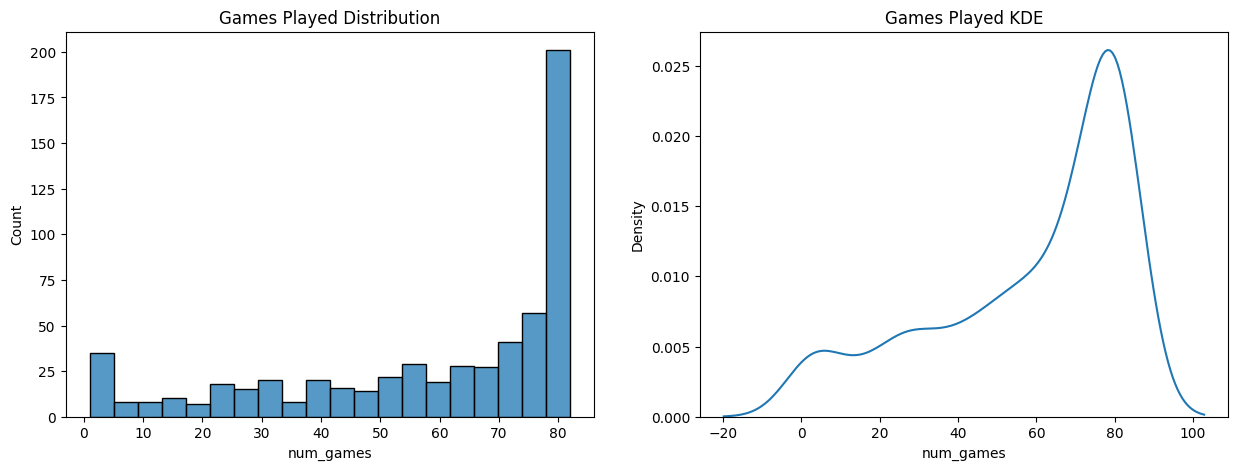

In [11]:
# Side by side plot for games played distribution and the kde plot
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.histplot(player_info['num_games'], bins=20, ax=ax[0])
ax[0].set_title('Games Played Distribution')
sns.kdeplot(player_info['num_games'], ax=ax[1])
ax[1].set_title('Games Played KDE')
plt.show()

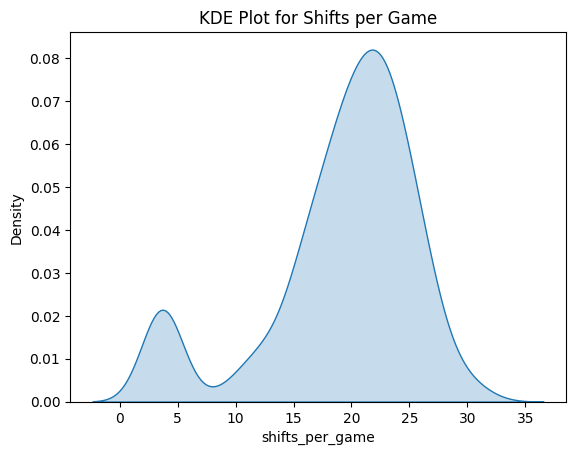

In [12]:
# KDE plot for shifts per game
sns.kdeplot(player_info['shifts_per_game'], fill=True)
plt.title('KDE Plot for Shifts per Game')
plt.show()

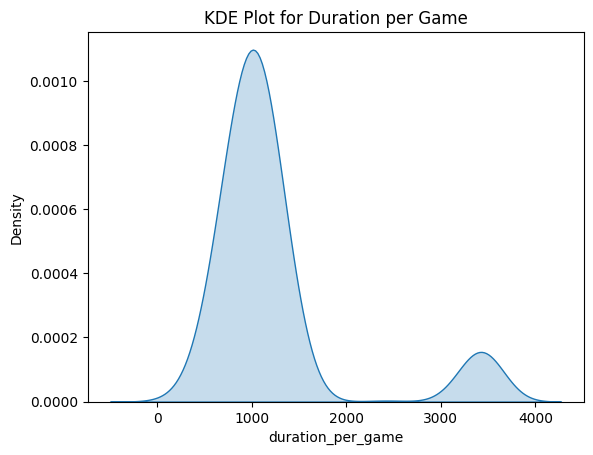

In [13]:
# KDE plot for duration per game
sns.kdeplot(player_info['duration_per_game'], fill=True)
plt.title('KDE Plot for Duration per Game')
plt.show()

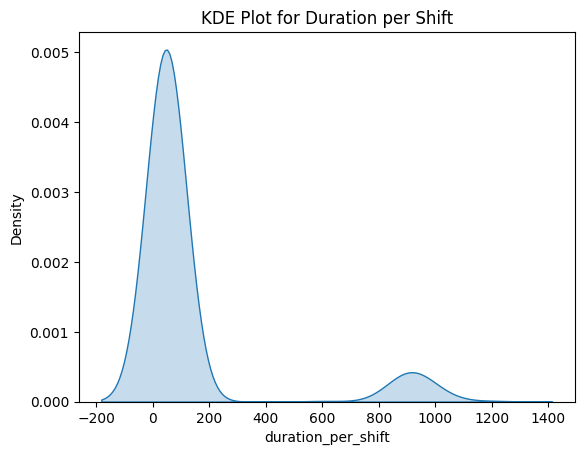

In [14]:
# KDE plot for duration per shift
sns.kdeplot(player_info['duration_per_shift'], fill=True)
plt.title('KDE Plot for Duration per Shift')
plt.show()

## Events EDA

In [15]:
events_df.rename(columns={'id' : 'unique_id'}, inplace=True)
events_df = events_df.merge(games_df[['id', 'season']], left_on='game_id', right_on='id')
events_df.drop(columns=['id'], inplace=True)
events_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379134 entries, 0 to 1379133
Data columns (total 15 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   unique_id                 1379134 non-null  int64  
 1   event_id                  1379134 non-null  int64  
 2   game_id                   1379134 non-null  int64  
 3   event_owner_team_id       1152773 non-null  float64
 4   period_number             1379134 non-null  int64  
 5   period_type               1379134 non-null  object 
 6   time_in_period            1379134 non-null  object 
 7   time_remaining            1379134 non-null  object 
 8   situation_code            1376200 non-null  float64
 9   home_team_defending_side  1378661 non-null  object 
 10  type_code                 1379134 non-null  int64  
 11  type_desc_key             1379134 non-null  object 
 12  sort_order                1379134 non-null  int64  
 13  event_details             1

In [16]:
events_df['type_desc_key'].unique()

array(['hit', 'period-start', 'faceoff', 'giveaway', 'stoppage',
       'shot-on-goal', 'missed-shot', 'blocked-shot', 'goal', 'takeaway',
       'penalty', 'period-end', 'delayed-penalty', 'game-end',
       'failed-shot-attempt', 'shootout-complete'], dtype=object)

In [17]:
# Buffalo v Minnesota play-by-play
buf_min = events_df[events_df['game_id'] == 2023020204]
buf_min.sort_values(by='sort_order', ascending=True, inplace=True)

for index, row in buf_min.iterrows():
    log = open('/Users/aidankosik/workspace/CSCA-5028/nhl-data-collector/datacollector/collection_scripts/logs/play_by_play_example.txt', 'a')
    log.write('At {} of period {}: A {} by {}\n'.format(row['time_remaining'], row['period_number'], row['type_desc_key'], row['event_owner_team_id']))

/var/folders/d6/3wvcj62d23z0cs353m5_sgtc0000gn/T/ipykernel_5372/3884070308.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  buf_min.sort_values(by='sort_order', ascending=True, inplace=True)


In [18]:
print(events_df.iloc[0])
events_df.iloc[0]['event_details']

unique_id                                                         22021020014
event_id                                                                    2
game_id                                                            2021020014
event_owner_team_id                                                      18.0
period_number                                                               1
period_type                                                               REG
time_in_period                                                          00:18
time_remaining                                                          19:42
situation_code                                                         1551.0
home_team_defending_side                                                 left
type_code                                                                 503
type_desc_key                                                             hit
sort_order                                                      

'{"xCoord": -27, "yCoord": -39, "zoneCode": "D", "eventOwnerTeamId": 18, "hittingPlayerId": 8475793, "hitteePlayerId": 8476467}'

In [19]:
# Get all the events without a event_owner_team_id
null_owner_events = events_df[events_df['event_owner_team_id'].isnull()]
null_owner_events.groupby(['type_desc_key', 'type_code'])['unique_id'].nunique()

type_desc_key      type_code
game-end           524            4401
period-end         521           14445
period-start       520           14458
shootout-complete  523             290
stoppage           516          192767
Name: unique_id, dtype: int64

In [20]:
# Filter out type codes 516, 520, 521, 523, 524
events_df = events_df[~events_df['type_code'].isin([516, 520, 521, 523, 524])]
events_df.groupby(['type_desc_key', 'type_code'])['unique_id'].nunique()

type_desc_key        type_code
blocked-shot         508          133195
delayed-penalty      535            8254
faceoff              502          249738
failed-shot-attempt  537              44
giveaway             504           74633
goal                 505           28112
hit                  503          205410
missed-shot          507          110055
penalty              509           34146
shot-on-goal         506          245987
takeaway             525           63199
Name: unique_id, dtype: int64

In [21]:
# For each game, get the number of events for each type_desc_key for each team
game_stats_df = events_df.groupby(['game_id', 'event_owner_team_id', 'type_desc_key'])['unique_id'].nunique().reset_index(name='num_events')
game_stats_df = game_stats_df.pivot_table(index=['game_id', 'event_owner_team_id'], columns='type_desc_key', values='num_events').reset_index()
# self join to get the stats for both teams in a game, but join where game_id = game_id and team_id != team_id
game_stats_df = game_stats_df.merge(game_stats_df, left_on='game_id', right_on='game_id', suffixes=('', '_opp'))
game_stats_df = game_stats_df[game_stats_df['event_owner_team_id'] != game_stats_df['event_owner_team_id_opp']]
game_stats_df.fillna(0, inplace=True)
game_stats_df.head(5)

type_desc_key,game_id,event_owner_team_id,blocked-shot,delayed-penalty,faceoff,failed-shot-attempt,giveaway,goal,hit,missed-shot,...,delayed-penalty_opp,faceoff_opp,failed-shot-attempt_opp,giveaway_opp,goal_opp,hit_opp,missed-shot_opp,penalty_opp,shot-on-goal_opp,takeaway_opp
1,2021020001,5.0,11.0,0.0,34.0,0.0,1.0,6.0,28.0,12.0,...,0.0,35.0,0.0,6.0,2.0,31.0,12.0,1.0,26.0,6.0
2,2021020001,14.0,15.0,0.0,35.0,0.0,6.0,2.0,31.0,12.0,...,0.0,34.0,0.0,1.0,6.0,28.0,12.0,1.0,29.0,2.0
5,2021020002,54.0,11.0,1.0,26.0,0.0,6.0,4.0,26.0,17.0,...,1.0,24.0,0.0,7.0,3.0,33.0,13.0,4.0,28.0,5.0
6,2021020002,55.0,19.0,1.0,24.0,0.0,7.0,3.0,33.0,13.0,...,1.0,26.0,0.0,6.0,4.0,26.0,17.0,4.0,26.0,10.0
9,2021020003,8.0,14.0,2.0,28.0,0.0,19.0,1.0,32.0,9.0,...,4.0,39.0,0.0,16.0,2.0,14.0,21.0,4.0,28.0,11.0


In [22]:
# Create an outcome column for the game, if goal > goal_opp then 1 else 0
game_stats_df['outcome'] = (game_stats_df['goal'] > game_stats_df['goal_opp']).astype(int)
game_stats_df.value_counts('outcome')

outcome
0    4429
1    4429
Name: count, dtype: int64

In [23]:
# Basic linear regression model to predict the outcome of a game
X = game_stats_df.drop(columns=['goal', 'goal_opp', 'outcome', 'game_id', 'event_owner_team_id', 'event_owner_team_id_opp'])
y = game_stats_df['outcome']

model = OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                outcome   R-squared (uncentered):                   0.543
Model:                            OLS   Adj. R-squared (uncentered):              0.542
Method:                 Least Squares   F-statistic:                              524.2
Date:                Sun, 28 Jul 2024   Prob (F-statistic):                        0.00
Time:                        10:28:50   Log-Likelihood:                         -6034.6
No. Observations:                8858   AIC:                                  1.211e+04
Df Residuals:                    8838   BIC:                                  1.225e+04
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
blocked-shot               -0.0096      0.001     -9.285      0.000      -0.012      -0.008
delayed-penalty             0.0002      0.006      0.037      0.971      -0.011       0.011
faceoff                     0.0083      0.001      9.350      0.000       0.007       0.010
failed-shot-attempt        -0.2767      0.068     -4.042      0.000      -0.411      -0.142
giveaway                   -0.0036      0.001     -2.957      0.003      -0.006      -0.001
hit                        -0.0077      0.001    -11.681      0.000      -0.009      -0.006
missed-shot                 0.0024      0.001      1.903      0.057   -7.16e-05       0.005
penalty                    -0.0223      0.003     -6.381      0.000      -0.029      -0.015
shot-on-goal               -0.0013      0.001     -1.602      0.109      -0.003       0.000
takeaway                    0.0223      0.001     14.970      0.000       0.019       0.025
blocked-shot_opp            0.0128      0.001     12.382      0.000       0.011       0.015
delayed-penalty_opp        -0.0036      0.006     -0.646      0.518      -0.014       0.007
faceoff_opp                -0.0024      0.001     -2.678      0.007      -0.004      -0.001
failed-shot-attempt_opp     0.2380      0.068      3.478      0.001       0.104       0.372
giveaway_opp                0.0049      0.001      4.032      0.000       0.003       0.007
hit_opp                     0.0085      0.001     12.915      0.000       0.007       0.010
missed-shot_opp             0.0031      0.001      2.451      0.014       0.001       0.005
penalty_opp                 0.0310      0.003      8.900      0.000       0.024       0.038
shot-on-goal_opp            0.0059      0.001      7.324      0.000       0.004       0.007
takeaway_opp               -0.0194      0.001    -12.998      0.000      -0.022      -0.016
==============================================================================
Omnibus:                    48229.424   Durbin-Watson:                   2.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              886.357
Skew:                           0.003   Prob(JB):                    3.39e-193
Kurtosis:                       1.450   Cond. No.                     1.12e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [24]:
X2 = X.drop(columns=['delayed-penalty', 'delayed-penalty_opp', 'shot-on-goal', 'missed-shot'])
model = OLS(y, X2)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                outcome   R-squared (uncentered):                   0.542
Model:                            OLS   Adj. R-squared (uncentered):              0.541
Method:                 Least Squares   F-statistic:                              654.8
Date:                Sun, 28 Jul 2024   Prob (F-statistic):                        0.00
Time:                        10:28:50   Log-Likelihood:                         -6037.4
No. Observations:                8858   AIC:                                  1.211e+04
Df Residuals:                    8842   BIC:                                  1.222e+04
Df Model:                          16                                                  
Covariance Type:            nonrobust                                                  
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
blocked-shot               -0.0095      0.001     -9.933      0.000      -0.011      -0.008
faceoff                     0.0082      0.001     10.194      0.000       0.007       0.010
failed-shot-attempt        -0.2809      0.068     -4.108      0.000      -0.415      -0.147
giveaway                   -0.0037      0.001     -3.090      0.002      -0.006      -0.001
hit                        -0.0076      0.001    -11.613      0.000      -0.009      -0.006
penalty                    -0.0220      0.003     -6.699      0.000      -0.028      -0.016
takeaway                    0.0223      0.001     15.044      0.000       0.019       0.025
blocked-shot_opp            0.0129      0.001     12.563      0.000       0.011       0.015
faceoff_opp                -0.0025      0.001     -2.995      0.003      -0.004      -0.001
failed-shot-attempt_opp     0.2392      0.068      3.495      0.000       0.105       0.373
giveaway_opp                0.0047      0.001      3.926      0.000       0.002       0.007
hit_opp                     0.0085      0.001     12.934      0.000       0.007       0.010
missed-shot_opp             0.0033      0.001      2.708      0.007       0.001       0.006
penalty_opp                 0.0303      0.003      9.257      0.000       0.024       0.037
shot-on-goal_opp            0.0058      0.001      7.232      0.000       0.004       0.007
takeaway_opp               -0.0194      0.001    -13.016      0.000      -0.022      -0.016
==============================================================================
Omnibus:                    48009.701   Durbin-Watson:                   2.934
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              888.936
Skew:                           0.003   Prob(JB):                    9.33e-194
Kurtosis:                       1.448   Cond. No.                     1.02e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Okay, so with 0 feature engineering our R-squared is 0.542, let's try to engineer some features.

Also, these are all __backward__ looking features, we need this to be predictive, maybe looking at the differentials between the two teams at any point. What's interesting, is that we assume roughly a 50/50 chance of winning before puck drop. 

In [54]:
# Get all goal events
shot_events = events_df[events_df['type_code'].isin([GOAL, SHOT_ON_GOAL, BLOCKED_SHOT, MISSED_SHOT, FAILED_SHOT_ATTEMPT])]

def getXCoord(row):
    '''
    Function to get the x coordinate of the shot
    @param row: row of a dataframe
    '''
    event_details = json.loads(row['event_details'])
    return event_details.get('xCoord')
    
def getYCoord(row):
    '''
    Function to get the y coordinate of the shot
    @param row: row of a dataframe
    '''
    event_details = json.loads(row['event_details'])
    return event_details.get('yCoord')

def getShootingPlayerId(row):
    '''
    Function to get the player id of the player who took the shot
    @param row: row of a dataframe
    '''
    event_details = json.loads(row['event_details'])
    if row['type_code'] == GOAL:
        return event_details.get('scoringPlayerId', '')
    else:
        return event_details.get('shootingPlayerId', '')
    
shot_events['xCoord'] = shot_events.apply(getXCoord, axis=1)
shot_events['yCoord'] = shot_events.apply(getYCoord, axis=1)

/var/folders/d6/3wvcj62d23z0cs353m5_sgtc0000gn/T/ipykernel_5372/2037331120.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/d6/3wvcj62d23z0cs353m5_sgtc0000gn/T/ipykernel_5372/2037331120.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
shot_events['type_code'].value_counts(normalize=True)

type_code
506    0.475436
508    0.257435
507    0.212711
505    0.054334
537    0.000085
Name: proportion, dtype: float64

In [27]:
class Rink():
    def __init__(self, data, hue_column):
        self.data = data
        self.hue_column = hue_column
        self.fig = px.scatter(self.data, x='xCoord', y='yCoord', color=self.hue_column, color_continuous_scale=px.colors.sequential.Plasma)
        
    def plot(self):
        self.plotBlueLines(self.fig)
        self.plotCenterIce(self.fig)
        self.plotGoalLines(self.fig)
        self.plotNets(self.fig)
        self.plotGoalMouth(self.fig)
        self.plotFaceoffDots(self.fig)
        
        self.fig.update_layout(
            width=2000,
            height=850,
            xaxis=dict(range=[-100, 100]),
            yaxis=dict(range=[-42.5, 42.5]),
            title="Hockey Rink"
        )
        
        self.fig.show()

    def plotBlueLines(self, fig):
        self.fig.add_shape(type="line", x0=25, x1=25, y0=-42.5, y1=42.5, line=dict(color="blue", width=2))
        self.fig.add_shape(type="line", x0=-25, x1=-25, y0=-42.5, y1=42.5, line=dict(color="blue", width=2))

    def plotCenterIce(self, fig):
        self.fig.add_shape(type="line", x0=0, x1=0, y0=-42.5, y1=42.5, line=dict(color="red", width=2, dash='dash'))
        self.fig.add_shape(type="circle", x0=-15, x1=15, y0=-15, y1=15, line=dict(color="blue", width=2))

    def plotGoalLines(self, fig):
        self.fig.add_shape(type="line", x0=89, x1=89, y0=-42.5, y1=42.5, line=dict(color="black", width=2))
        self.fig.add_shape(type="line", x0=-89, x1=-89, y0=-42.5, y1=42.5, line=dict(color="black", width=2))

    def plotNets(self, fig):
        self.fig.add_shape(type="rect", x0=-92, x1=-89, y0=3, y1=-3, line=dict(color="black", width=2))
        self.fig.add_shape(type="rect", x0=89, x1=92, y0=3, y1=-3, line=dict(color="black", width=2))

    def plotGoalMouth(self, fig):
        self.fig.add_shape(type="circle", x0=83, x1=95, y0=-6, y1=6, line=dict(color="blue", width=2), fillcolor="blue", opacity=0.4)
        self.fig.add_shape(type="circle", x0=-95, x1=-83, y0=-6, y1=6, line=dict(color="blue", width=2), fillcolor="blue", opacity=0.4)

    def plotFaceoffDots(self, fig):
        faceoff_dots = [
            (69, 22), (-69, 22), (69, -22), (-69, -22)
        ]
        for x, y in faceoff_dots:
            self.fig.add_shape(type="circle", x0=x-1, x1=x+1, y0=y-1, y1=y+1, line=dict(color="red", width=2), fillcolor="red", opacity=0.4)
            self.fig.add_shape(type="circle", x0=x-15, x1=x+15, y0=y-15, y1=y+15, line=dict(color="red", width=2))
            
            # Add hash marks
            if y > 0:
                self.fig.add_shape(type="line", x0=x+1, x1=x+1, y0=y-15, y1=y-16, line=dict(color="red", width=2))
                self.fig.add_shape(type="line", x0=x-1, x1=x-1, y0=y-15, y1=y-16, line=dict(color="red", width=2))
            else:
                self.fig.add_shape(type="line", x0=x+1, x1=x+1, y0=y+15, y1=y+16, line=dict(color="red", width=2))
                self.fig.add_shape(type="line", x0=x-1, x1=x-1, y0=y+15, y1=y+16, line=dict(color="red", width=2))

    # Provide a column name to update the tooltip
    def updateTooltip(self, tooltip_column):
        self.fig.update_traces(hovertemplate='<b>%{customdata[0]}</b><br>X: %{x}<br>Y: %{y}<extra></extra>', customdata=[tooltip_column])


In [28]:
SHOT_ON_GOAL

506

In [29]:
# Plot a scatter plot with x and y coordinates as the x and y axis, use color to denote how many goals were scored like a heatmap
# first, get all unique x and y coordinates combinations
shots_on_goal = shot_events[shot_events['type_code'] == SHOT_ON_GOAL]
shot_coords = shots_on_goal.groupby(['xCoord', 'yCoord'])['unique_id'].nunique().reset_index(name='num_shots')

# calculate the number of goals scored at each coordinate, type_code 505 is goal
goal_coords = shot_events[shot_events['type_code'] == GOAL]
goal_coords = goal_coords.groupby(['xCoord', 'yCoord'])['unique_id'].nunique().reset_index(name='num_goals')

# join the shot_coords with goal_coords to get the number of goals scored at each coordinate
shot_coords = shot_coords.merge(goal_coords, on=['xCoord', 'yCoord'], how='left')
shot_coords.fillna(0, inplace=True)

# the total shots are actually num_shots + num_goals as we don't record goals as shots
shot_coords['total_shots'] = shot_coords['num_shots'] + shot_coords['num_goals']

# Create shootingPct column
shot_coords['shootingPct'] = shot_coords['num_goals'] / shot_coords['total_shots']
shot_coords.sort_values('shootingPct', ascending=False, inplace=True)
shot_coords.head(5)

,xCoord,yCoord,num_shots,num_goals,total_shots,shootingPct
14393,88.0,2.0,2,12.0,14.0,0.857143
485,-89.0,-2.0,1,3.0,4.0,0.750000
628,-87.0,1.0,2,5.0,7.0,0.714286
14392,88.0,1.0,2,5.0,7.0,0.714286
14391,88.0,0.0,2,5.0,7.0,0.714286


In [30]:
# How many locations are there?
shot_coords[['xCoord', 'yCoord']].nunique()
# 200 * 85 = 17000 locations

xCoord    200
yCoord     85
dtype: int64

In [31]:
# How many locations have no goals scored?
shot_coords[shot_coords['num_goals'] == 0].shape[0]

8609

In [32]:
# remove areas with no goals
shot_coords = shot_coords[shot_coords['num_goals'] > 0]
# plot the rink
rink = Rink(shot_coords, 'shootingPct')
rink.plot()

In [33]:
rink = Rink(shot_coords, 'num_goals')
rink.plot()

In [34]:
# Lets think about this in a more complex way, when a shot is taken there are X outcomes:
# 1. Goal (505)
# 2. Shot-on-Goal (506)
# 3. Missed Shot (507)
# 4. Blocked Shot (508)
# 5. Failed Shot Attempt (537)
# Lets consider the total shot attempts as the sum of all the above outcomes, total shots = GOAL + SHOT_ON_GOAL + MISSED_SHOT + BLOCKED_SHOT + FAILED_SHOT_ATTEMPT

# Sum the types of shot attempts in the events_df
shot_attempts = shot_events.groupby(['xCoord', 'yCoord', 'type_desc_key'])['unique_id'].nunique().reset_index(name='num_attempts')
shot_attempts = shot_attempts.pivot_table(index=['xCoord', 'yCoord'], columns='type_desc_key', values='num_attempts').reset_index()
shot_attempts.fillna(0, inplace=True)
shot_attempts['total_attempts'] = shot_attempts['goal'] + shot_attempts['shot-on-goal'] + shot_attempts['missed-shot'] + shot_attempts['blocked-shot'] + shot_attempts['failed-shot-attempt']
shot_attempts['total_shots'] = shot_attempts['goal'] + shot_attempts['shot-on-goal']

# Lets calculate the probability of a shot attempt resulting in a goal, block, miss or failed attempt
shot_attempts['goalProb'] = shot_attempts['goal'] / shot_attempts['total_attempts']
shot_attempts['blockProb'] = shot_attempts['blocked-shot'] / shot_attempts['total_attempts']
shot_attempts['missProb'] = shot_attempts['missed-shot'] / shot_attempts['total_attempts']
shot_attempts['failedProb'] = shot_attempts['failed-shot-attempt'] / shot_attempts['total_attempts']
shot_attempts['shotProb'] = shot_attempts['shot-on-goal'] / shot_attempts['total_attempts']

shot_attempts['summedProb'] = shot_attempts['goalProb'] + shot_attempts['blockProb'] + shot_attempts['missProb'] + shot_attempts['failedProb'] + shot_attempts['shotProb']
# What percent of rows have a summedProb of 1?
print('{:.2f}% of rows have a summedProb of 1'.format(shot_attempts[shot_attempts['summedProb'] == 1].shape[0] / shot_attempts.shape[0] * 100))

# What are the top 5 locations with the highest goal probability?
shot_attempts.sort_values('goalProb', ascending=False, inplace=True)

rink = Rink(shot_attempts, 'goalProb')
rink.plot()

print(shot_attempts.head(10))

98.52% of rows have a summedProb of 1


type_desc_key  xCoord  yCoord  blocked-shot  failed-shot-attempt  goal  \
7075             -8.0     5.0           0.0                  0.0   1.0   
8211              7.0   -20.0           0.0                  0.0   1.0   
6444            -17.0     5.0           0.0                  0.0   1.0   
9017             18.0   -13.0           0.0                  0.0   1.0   
7348             -4.0   -29.0           0.0                  0.0   1.0   
89              -97.0    20.0           0.0                  0.0   1.0   
5903            -24.0   -23.0           0.0                  0.0   1.0   
14971            91.0     1.0           0.0                  0.0   1.0   
5904            -24.0   -22.0           0.0                  0.0   1.0   
67              -97.0    -8.0           0.0                  0.0   1.0   

type_desc_key  missed-shot  shot-on-goal  total_attempts  total_shots  \
7075                   0.0           0.0             1.0          1.0   
8211                   0.0           0.

The locations with the highest goal probability are locations that rarely see shot attempts. We should consider only looking at locations with a certain threshold of shot attempts.

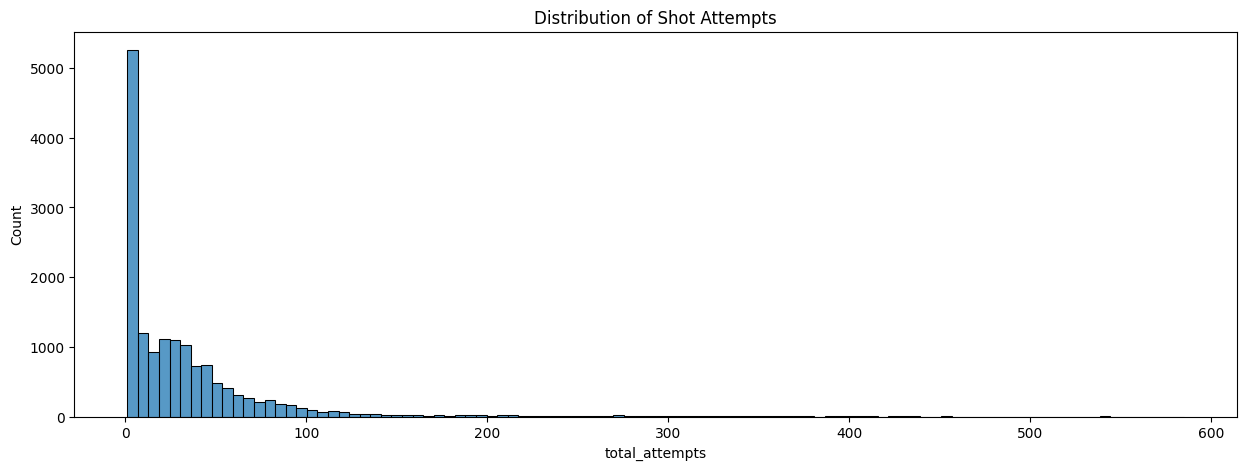

In [35]:
# Lets plot the distribution of shot attempts
plt.figure(figsize=(15, 5))
sns.histplot(shot_attempts['total_attempts'], bins=100)
plt.title('Distribution of Shot Attempts')
plt.show()

In [36]:
shot_attempts['total_attempts'].describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.95])

count    15383.00000
mean        33.62257
std         48.79627
min          1.00000
5%           1.00000
10%          2.00000
25%          4.00000
50%         20.00000
75%         43.00000
95%        111.00000
max        585.00000
Name: total_attempts, dtype: float64

In [37]:
# Let's only look at locations with at least 3 shot attempts
filtered_shot_attempts = shot_attempts[shot_attempts['total_attempts'] >= 20]

rink = Rink(filtered_shot_attempts, 'goalProb')
rink.plot()

In [38]:
# What if we take the absolute value of the coordinates? We would sum all the measures for the same location.
# Lets create a new dataframe with the absolute value of the coordinates and their measures
abs_shot_attempts = shot_attempts.copy()
abs_shot_attempts['xCoord'] = abs_shot_attempts['xCoord'].abs()

abs_shot_attempts = abs_shot_attempts.groupby(['xCoord', 'yCoord']).sum().reset_index()

abs_shot_attempts['total_attempts'].describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.95])

count    8073.000000
mean       64.067385
std        95.789160
min         1.000000
5%          2.000000
10%         3.000000
25%         6.000000
50%        37.000000
75%        82.000000
95%       214.400000
max      1098.000000
Name: total_attempts, dtype: float64

In [39]:
filtered_abs_shot_attempts = abs_shot_attempts[abs_shot_attempts['total_attempts'] >= 6]

rink = Rink(filtered_abs_shot_attempts, 'goalProb')
rink.plot()

In [40]:
filtered_abs_shot_attempts.columns

Index(['xCoord', 'yCoord', 'blocked-shot', 'failed-shot-attempt', 'goal',
       'missed-shot', 'shot-on-goal', 'total_attempts', 'total_shots',
       'goalProb', 'blockProb', 'missProb', 'failedProb', 'shotProb',
       'summedProb'],
      dtype='object', name='type_desc_key')

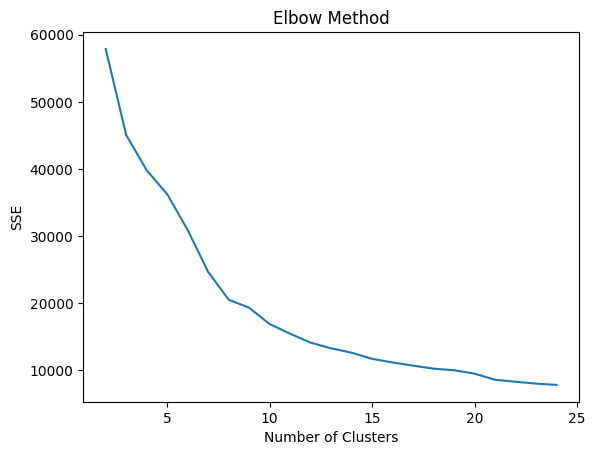

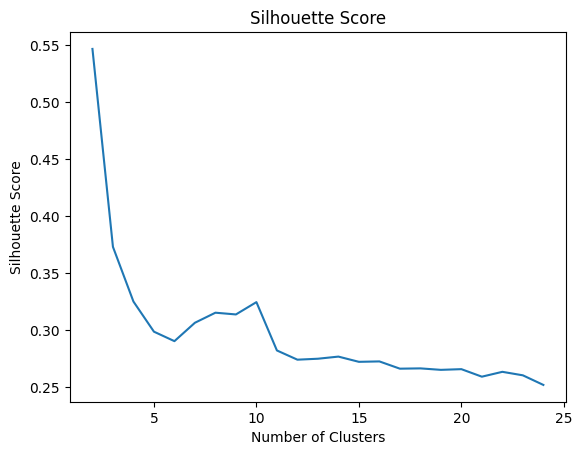

In [41]:
# Can we use clustering to identify high danger areas and low danger areas?
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Lets use the absolute shot attempts dataframe
X = filtered_abs_shot_attempts.drop(columns=['xCoord', 'yCoord'])
X_scaled = scaler.fit_transform(X)

sse = []
sil_scores = []
for k in range(2, 25):
    kmeans = KMeans(n_clusters=k, random_state=11)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)
    sil_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.plot(range(2, 25), sse)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

plt.plot(range(2, 25), sil_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [42]:
kmeans = KMeans(n_clusters=10, random_state=11)
filtered_abs_shot_attempts['cluster'] = kmeans.fit_predict(X_scaled)

/var/folders/d6/3wvcj62d23z0cs353m5_sgtc0000gn/T/ipykernel_5372/3695675779.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
rink = Rink(filtered_abs_shot_attempts, 'cluster')
rink.plot()

In [73]:
cluster_names = {
    0: 'Outer Zone',
    1: 'High Slot',
    2: 'Below Goal Line/ Outside Zone',
    3: 'Low-Event Areas',
    4: 'Inner Zone',
    5: 'Central-Low Slot',
    6: 'High-Slot 2 (Failed Attempts)',
    7: 'Low-Event Area',
    8: 'Low Slot',
    9: 'Blue Paint'
}

In [44]:
cluster_summary = filtered_abs_shot_attempts.groupby('cluster').agg({
    'goal': 'sum',
    'blocked-shot': 'sum',
    'failed-shot-attempt': 'sum',
    'missed-shot': 'sum',
    'shot-on-goal': 'sum',
    'total_attempts': 'sum',
    'total_shots': 'sum',
    'goalProb': 'mean',
    'blockProb': 'mean',
    'missProb': 'mean',
    'failedProb': 'mean',
    'shotProb': 'mean'
}).reset_index()

cluster_summary.sort_values('goalProb', ascending=False)

type_desc_key,cluster,goal,blocked-shot,failed-shot-attempt,missed-shot,shot-on-goal,total_attempts,total_shots,goalProb,blockProb,missProb,failedProb,shotProb
9,9,811.0,688.0,0.0,369.0,1601.0,3469.0,2412.0,0.494816,0.223795,0.259502,0.000000,1.021887
5,5,1482.0,2873.0,14.0,1683.0,5494.0,11546.0,6976.0,0.255850,0.499030,0.289512,0.002497,0.953111
8,8,6788.0,18799.0,0.0,10869.0,27664.0,64120.0,34452.0,0.211001,0.578571,0.342154,0.000000,0.868274
6,6,973.0,4299.0,28.0,1955.0,3761.0,11016.0,4734.0,0.168614,0.794682,0.356121,0.005832,0.674750
1,1,8111.0,54347.0,0.0,21755.0,40978.0,125191.0,49089.0,0.127769,0.866745,0.345950,0.000000,0.659536
4,4,7020.0,44231.0,0.0,35921.0,84558.0,171730.0,91578.0,0.075942,0.513423,0.420132,0.000000,0.990503
3,3,2.0,3.0,2.0,25.0,41.0,73.0,43.0,0.048611,0.078023,0.699988,0.050245,1.123133
0,0,2250.0,7039.0,0.0,33688.0,62891.0,105868.0,65141.0,0.040961,0.110125,0.673038,0.000000,1.175877
7,7,7.0,2.0,0.0,30.0,199.0,238.0,206.0,0.031157,0.007812,0.123966,0.000000,0.837065
2,2,294.0,807.0,0.0,2881.0,14242.0,18224.0,14536.0,0.029841,0.045539,0.260634,0.000000,1.663986


In [45]:
# What is the cluster breakdown where x > 89?
filtered_abs_shot_attempts[filtered_abs_shot_attempts['xCoord'] > 89].groupby('cluster').size()

cluster
0    127
2    141
4      1
7      3
9     23
dtype: int64

In [46]:
# Lets save to a CSV the output of locations with their cluster
filtered_abs_shot_attempts.to_csv('/Users/aidankosik/workspace/CSCA-5028/nhl-data-collector/datacollector/collection_scripts/filtered_abs_shot_attempts.csv', index=False)

In [47]:
GOAL

505

In [51]:
shot_events.groupby('type_code')['unique_id'].nunique()

type_code
505     28112
506    245987
507    110055
508    133195
537        44
Name: unique_id, dtype: int64

In [53]:
shot_events[shot_events['type_code'] == GOAL].iloc[0]['event_details']

'{"xCoord": -65, "yCoord": -27, "zoneCode": "O", "shotType": "wrist", "scoringPlayerId": 8478042, "scoringPlayerTotal": 23, "assist1PlayerId": 8477942, "assist1PlayerTotal": 47, "assist2PlayerId": 8476479, "assist2PlayerTotal": 33, "eventOwnerTeamId": 26, "goalieInNetId": 8480981, "awayScore": 0, "homeScore": 1}'

In [58]:
# for each x, y pair who is the most likely to score a goal?
events_of_interest = shot_events.copy()
events_of_interest['shooter_id'] = events_of_interest.apply(getShootingPlayerId, axis=1)

events_of_interest['abs_x'] = events_of_interest['xCoord'].abs()
events_of_interest['abs_y'] = events_of_interest['yCoord'].abs()

goal_scorers_events = events_of_interest.merge(players_df[['id', 'full_name']], how='left', left_on='shooter_id', right_on='id')
goal_scorers_events = goal_scorers_events.merge(filtered_abs_shot_attempts[['xCoord', 'yCoord', 'cluster']], left_on=['abs_x', 'abs_y'], right_on=['xCoord', 'yCoord'], how='left', suffixes=('', '_cluster'))
goal_scorers_events.drop(columns=['id', 'xCoord_cluster', 'yCoord_cluster'], inplace=True)

# calculate shooting percentage for each player by cluster, shooting percentage = goals / shots
goals = goal_scorers_events[goal_scorers_events['type_code'] == GOAL].groupby(['full_name', 'cluster'])['unique_id'].nunique().reset_index(name='num_goals')
goals

,full_name,cluster,num_goals
0,"Abruzzese, Nick",4.0,1
1,"Abruzzese, Nick",6.0,1
2,"Abruzzese, Nick",8.0,1
3,"Acciari, Noel",1.0,9
4,"Acciari, Noel",4.0,3
...,...,...,...
2909,"Zuccarello, Mats",8.0,21
2910,"van Riemsdyk, Trevor",0.0,3
2911,"van Riemsdyk, Trevor",1.0,2
2912,"van Riemsdyk, Trevor",4.0,3


In [84]:
# For each cluster, which full_name has the most goals
goal_scorers = goal_scorers_events[goal_scorers_events['type_code'] == GOAL].groupby(['full_name', 'cluster'])['unique_id'].nunique().reset_index(name='num_goals')
player_attempts = goal_scorers_events[goal_scorers_events['type_code'].isin([SHOT_ON_GOAL, GOAL, BLOCKED_SHOT, MISSED_SHOT, FAILED_SHOT_ATTEMPT])].groupby(['full_name', 'cluster'])['unique_id'].nunique().reset_index(name='num_attempts')
goal_scorers = goal_scorers.merge(player_attempts, on=['full_name', 'cluster'])
goal_scorers['shootingPct'] = goal_scorers['num_goals'] / goal_scorers['num_attempts']
goal_scorers['weighted_goals'] = goal_scorers['num_goals'] * goal_scorers['shootingPct']
# add cluster names to the df
goal_scorers['cluster_name'] = goal_scorers['cluster'].map(cluster_names)
out = goal_scorers[goal_scorers['num_attempts'] > 1]
# get the top player for each cluster
out = out.loc[out.groupby('cluster')['weighted_goals'].idxmax()]
out.sort_values('cluster', ascending=False)
out.head(10)

,full_name,cluster,num_goals,num_attempts,shootingPct,weighted_goals,cluster_name
604,"Draisaitl, Leon",0.0,23,274,0.083942,1.930657,Outer Zone
2339,"Robertson, Jason",1.0,56,485,0.115464,6.465979,High Slot
2384,"Rust, Bryan",2.0,5,36,0.138889,0.694444,Below Goal Line/ Outside Zone
892,"Gaudreau, Johnny",3.0,1,2,0.500000,0.500000,Low-Event Areas
2144,"Pastrnak, David",4.0,71,907,0.078280,5.557883,Inner Zone
2878,"Zegras, Trevor",5.0,9,21,0.428571,3.857143,Central-Low Slot
1689,"MacKinnon, Nathan",6.0,8,35,0.228571,1.828571,High-Slot 2 (Failed Attempts)
534,"DeBrincat, Alex",7.0,1,2,0.500000,0.500000,Low-Event Area
1466,"Kreider, Chris",8.0,79,405,0.195062,15.409877,Low Slot
1542,"Lafrenière, Alexis",9.0,6,9,0.666667,4.000000,Blue Paint


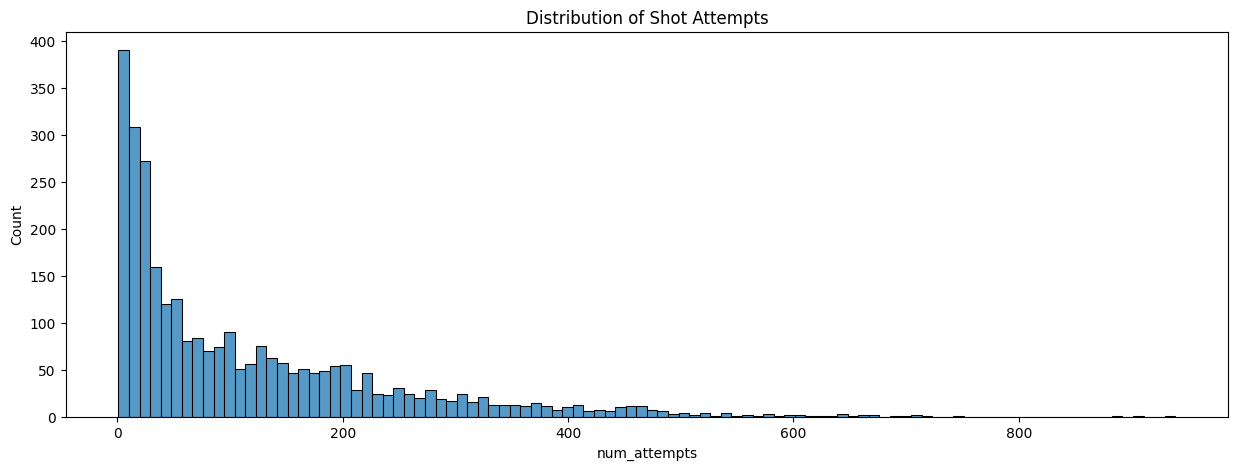

count    2914.000000
mean      115.692862
std       128.543447
min         1.000000
5%          5.000000
10%         8.300000
25%        21.000000
50%        67.000000
75%       172.750000
95%       382.350000
max       939.000000
Name: num_attempts, dtype: float64

In [80]:
# What is the distribution of number of attempts?
plt.figure(figsize=(15, 5))
sns.histplot(goal_scorers['num_attempts'], bins=100)
plt.title('Distribution of Shot Attempts')
plt.show()

goal_scorers['num_attempts'].describe(percentiles=[0.05, 0.10, 0.25, 0.50, 0.75, 0.95])

In [61]:
cluster_summary.sort_values('goalProb', ascending=False)

type_desc_key,cluster,goal,blocked-shot,failed-shot-attempt,missed-shot,shot-on-goal,total_attempts,total_shots,goalProb,blockProb,missProb,failedProb,shotProb
9,9,811.0,688.0,0.0,369.0,1601.0,3469.0,2412.0,0.494816,0.223795,0.259502,0.000000,1.021887
5,5,1482.0,2873.0,14.0,1683.0,5494.0,11546.0,6976.0,0.255850,0.499030,0.289512,0.002497,0.953111
8,8,6788.0,18799.0,0.0,10869.0,27664.0,64120.0,34452.0,0.211001,0.578571,0.342154,0.000000,0.868274
6,6,973.0,4299.0,28.0,1955.0,3761.0,11016.0,4734.0,0.168614,0.794682,0.356121,0.005832,0.674750
1,1,8111.0,54347.0,0.0,21755.0,40978.0,125191.0,49089.0,0.127769,0.866745,0.345950,0.000000,0.659536
4,4,7020.0,44231.0,0.0,35921.0,84558.0,171730.0,91578.0,0.075942,0.513423,0.420132,0.000000,0.990503
3,3,2.0,3.0,2.0,25.0,41.0,73.0,43.0,0.048611,0.078023,0.699988,0.050245,1.123133
0,0,2250.0,7039.0,0.0,33688.0,62891.0,105868.0,65141.0,0.040961,0.110125,0.673038,0.000000,1.175877
7,7,7.0,2.0,0.0,30.0,199.0,238.0,206.0,0.031157,0.007812,0.123966,0.000000,0.837065
2,2,294.0,807.0,0.0,2881.0,14242.0,18224.0,14536.0,0.029841,0.045539,0.260634,0.000000,1.663986
